In [32]:

from scipy import stats

import matplotlib.pyplot as plt
import numpy as np

import numpy.random as rd

import pandas as pd 

from tqdm import tqdm
import math
import autograd.numpy as np # Numpy用の薄いラッパ
from autograd import grad

In [43]:
class HMC():
    def __init__(self ,param = {}):
        self._auto = self._grad(self._h)
        self.param =  param
        
    def _h(self, x,param):
        """
        こいつがポテンシャルエネルギー的なもの。

        確率密度のlogをとり、マイナスをつける。関係のあるものだけにする
        """
        mu,sigma = list(param.values())

        return (x-mu)**2/(2 * sigma)
    
    def _grad(self,h):
        return grad(h)


    def _delta_h(self,x,param):
        return  self._auto(float(x), param)
        
    def _momentum(self, p):
        """
        運動エネルギーは 正規乱数のlog(= -0.5 * p**2)にマイナスをくっつけたもの
        """
        return 0.5 * p**2
    
    def _hamiltonian(self,x,p):
        return self._h(x,self.param) + self._momentum(p)
    
    def _LeapFrog(self,x,p, eta, L, stlide=1):
        for _ in range(L):
            p = p - 0.5*eta* self._delta_h(x,self.param)
            x = x + eta * p
            p = p - 0.5*eta* self._delta_h(x,self.param)
        return x,p
    
    def _sampler(self,T,L,eta):
        x = rd.normal(loc=10,scale=10)
        p = rd.normal(loc=0,scale=1)
        prev_hamiltonian = self._hamiltonian(x,p)
        sim_result = [[x,p,prev_hamiltonian, True]]
        for t in range(T):
            prev_x,prev_p,prev_hamiltonian = x,p,self._hamiltonian(x,p)
            x,p = self._LeapFrog(x,p,eta,L= L)
            H = self._hamiltonian(x,p)
            # 本当は、np.exp(-H)/np.exp(-prev_hamiltonian)
            # 上を展開して整理した
            r = np.exp(prev_hamiltonian-H)
            if  rd.uniform() < r:
                sim_result.append([ x,p,self._hamiltonian(x,p), True])
            else:
                print("Not accpected")
                sim_result.append([ x,p,self._hamiltonian(x,p), False])
                x = prev_x
            p = rd.normal(loc=0,scale=1) 
        print("Accept_rate: {:.6f}".format(sum(np.array(sim_result)[:,3])/len(np.array(sim_result)[:,3])))
        return sim_result
    
    def Sampling(self,T=1000,L = 100,eta = 0.01,chain =4,burn_in_rate = 0.1):
        self.all_result = []
        self.burn_in = []
        self.chain = chain
        
        for _ in tqdm(range(0,chain)):
            result = np.array(self._sampler(T,L,eta))
            burn_in = int(len(result)*burn_in_rate)
            self.burn_in.append(burn_in)
            self.all_result.append(result[:,0])

        
    def get_r_hat(self):
        """
        収束診断の為の値　r_hat
        完全なものではないのであとで修正
        :return:
        """

        result = np.array(self.all_result)
       # 全体平均
        overall_ave = np.mean(result.flatten())
        # 各列の平均
        chain_ave = np.mean(result, axis=1)

        # Nの数(各チェインごとの長さ)
        N = np.array([i.shape[0] for i in result])
        # Mの数(チェインの数)
        M = result.shape[0]

        # 全体平均と個々の分散
        s = 1 / (N - 1) * np.sum((result - overall_ave) ** 2,axis=1) 

        # サンプル内分散
        W = 1 / M * np.sum(s)

        first_var_hat =1/M * np.sum(1/N * np.sum((result - overall_ave) ** 2,axis=1))


        second_var_hat = 1/(M-1) * np.sum((overall_ave -chain_ave ) ** 2)
        
        var_hat = first_var_hat + second_var_hat

        return (var_hat / W) ** 0.5
    
    def trace_plot(self):
        fig = plt.figure()
        for i in range(0,self.chain):
            ax1 = fig.add_subplot(self.chain, 1, i+1)
            burn_in = self.burn_in[i]
            result = self.all_result[i]
            ax1.plot(range(burn_in), result[:burn_in], lw=0.2, color="gray")
            ax1.plot(range(burn_in,len(result)), result[burn_in:], lw=0.2)
            ax1.set_title('chain_{}'.format(i))
        fig.tight_layout()
        plt.show()
    
    def trace_all_plot(self):
        fig = plt.figure()
        ax1 = fig.add_subplot(1,1,1)
        for i in range(0,self.chain):
            burn_in = self.burn_in[i]
            result = self.all_result[i]
            ax1.plot(range(burn_in,len(result)), result[burn_in:],alpha = 0.3, lw=0.2)
        plt.show()
    
    def plot(self):
        fig = plt.figure()
        for i in range(0,self.chain):
            ax1 = fig.add_subplot(self.chain, 2, i+1)
            burn_in = self.burn_in[i]
            result = self.all_result[i]
            ax1.hist(result[burn_in:], alpha = 0.3, normed=True)
        fig.tight_layout()
        plt.show()

# 既知の分布からサンプリング


平均5, 分散1の分布から、値をサンプリング

In [44]:
param = {"mu":5.0,"sigma":1.0}

In [45]:
instance = HMC(param = param)   

In [46]:
result = instance.Sampling(T=4000,L = 100,eta = 0.01,chain =1)

  0%|          | 0/1 [00:00<?, ?it/s]


TypeError: 'float' object does not support item assignment

# 描画

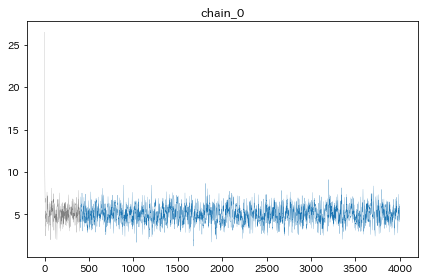

In [38]:
instance.trace_plot()

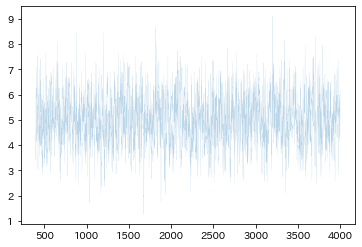

In [39]:
instance.trace_all_plot()

/Users/kojisugano/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:133: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


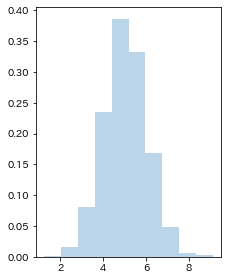

In [40]:
instance.plot()

In [41]:
np_normal = np.random.normal(
    loc   = 5,      # 平均
    scale = 1,      # 標準偏差
    size  = 1000,)

/Users/kojisugano/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


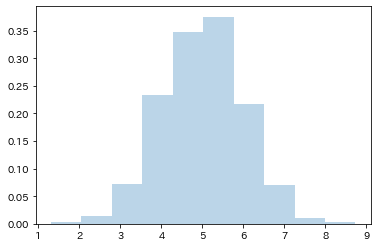

In [42]:
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.hist(np_normal, alpha = 0.3,  normed=True)
plt.show()     